In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [3]:
train_transform = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(64, 64), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    # v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 32

trainset = ImageFolder("train/", transform=train_transform)

train_set, val_set = torch.utils.data.random_split(trainset, [0.8, 0.2])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


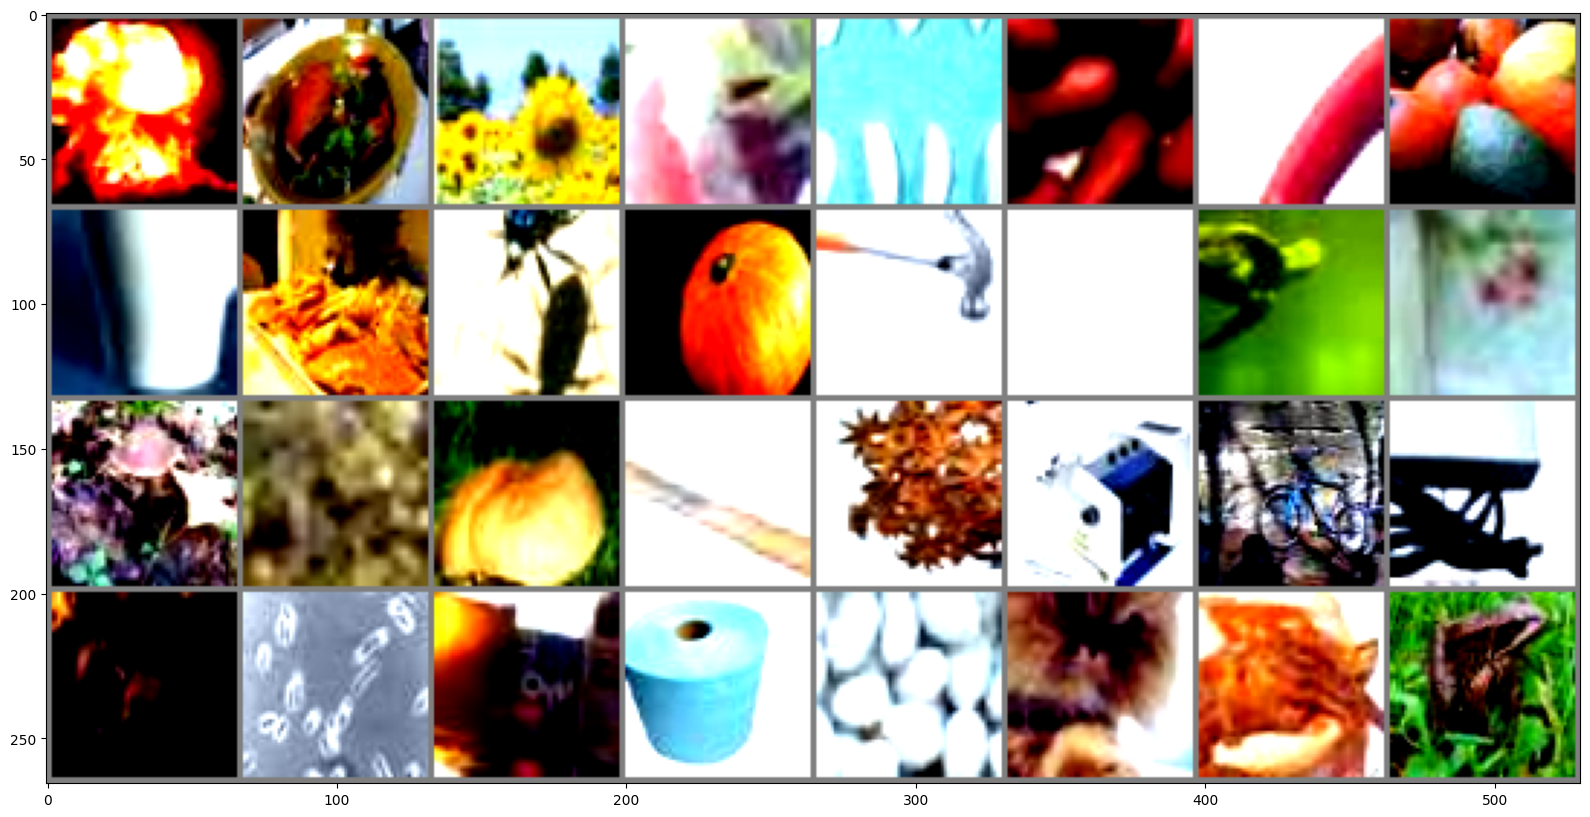

In [4]:
plt.figure(figsize = (20,10))

images, labels = next(iter(trainloader))

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images, labels = next(iter(trainloader))

imshow(torchvision.utils.make_grid(images))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=90, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(90, 120, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(120 * 13 * 13, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 50)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 90, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(90, 120, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20280, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=50, bias=True)
)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
losses = []
for epoch in range(32):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('[%d/5] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    losses.append(running_loss / 2000)
    running_loss = 0.0

print('Finished Training')

[1/5] loss: 3.941
[2/5] loss: 3.676
[3/5] loss: 3.588
[4/5] loss: 3.537
[5/5] loss: 3.473
[6/5] loss: 3.419
[7/5] loss: 3.360
[8/5] loss: 3.302
[9/5] loss: 3.259
[10/5] loss: 3.205
[11/5] loss: 3.164
[12/5] loss: 3.136
[13/5] loss: 3.106
[14/5] loss: 3.072
[15/5] loss: 3.065
[16/5] loss: 3.035
[17/5] loss: 3.013
[18/5] loss: 2.995
[19/5] loss: 2.980
[20/5] loss: 2.964
[21/5] loss: 2.958
[22/5] loss: 2.943
[23/5] loss: 2.942
[24/5] loss: 2.925
[25/5] loss: 2.912
[26/5] loss: 2.911
[27/5] loss: 2.893
[28/5] loss: 2.910
[29/5] loss: 2.883
[30/5] loss: 2.877
[31/5] loss: 2.912
[32/5] loss: 2.866
Finished Training


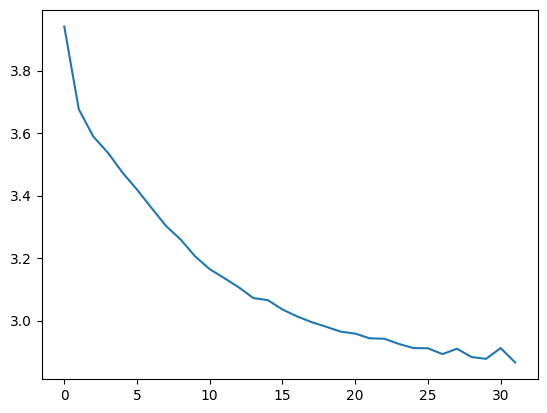

In [8]:
plt.plot(losses)
plt.show()

In [9]:
net.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
    
        outputs = net(inputs)
        output = torch.argmax(outputs, dim=1)
    
        y_pred_list.extend(output.cpu().numpy().tolist())
        y_true_list.extend(labels.cpu().numpy().tolist())

correct_predictions = sum([1 for i in range(len(y_pred_list)) if y_pred_list[i] == y_true_list[i]])
accuracy = (correct_predictions / len(y_pred_list)) * 100

print(f"Classification accuracy: {accuracy:.2f}%")

Classification accuracy: 29.25%
